# Data Modeling Notebook

---

## 1. Imports
Load all libraries required for data preprocessing, model training, evaluation, and visualization.

In [1]:
import os
import polars as pl
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings

# Split, evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras import layers, models

# Graphs
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

---

## 2. Load the cleaned dataset
Load the prepared IoT traffic dataset, already processed in the previous notebook. This dataset is the final modeling input.

In [3]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars this gives us a lazy dataframe that we can manipulate without loading the entire dataset into memory
lazy_frame = pl.scan_parquet(PATH)

---

## 3. Define features and target
Select all numerical features as predictors and use the grouped **Label** column as the target.

In [4]:
# Target column
TARGET_COL = "Label_Family"    

# Columns that should NEVER be used as features
label_like_cols = ["Label", "Label_Family", "Label_Binary"]

# Work out which columns are features
schema = lazy_frame.collect_schema()
all_cols = list(schema.keys())

# Exclude all label columns from the feature set
feature_cols = [c for c in all_cols if c not in label_like_cols]

In [5]:
# Collect just the columns we need into memory
df = lazy_frame.select(feature_cols + label_like_cols).collect()

### 3.1 Class-balanced sampling
Apply class-balanced sampling to reduce extreme imbalance and ensure all attack families appear during training.


In [6]:
# Number of rows per category 200,000
N = 200000

# shuffle first so head(N) is effectively a random sample per class
df_shuffled = df.sample(fraction=1.0, with_replacement=False, seed=42)

df_balanced = (
    df_shuffled
        .group_by("Label_Family")
        .head(N)
)

In [7]:
# Convert to NumPy for the models
X = df_balanced.select(feature_cols).to_numpy()
y = df_balanced.get_column(TARGET_COL).to_numpy()

In [8]:
# Encoding the target variable because it is categorical
le = LabelEncoder()
y_encoded = le.fit_transform(df_balanced.get_column("Label_Family").to_numpy())
num_classes = len(le.classes_)

---

## 4. Train / test split
Split the dataset into training and testing partitions to evaluate model generalization.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

---

## 5. Model Selection Rationale
We compare classical ensemble models (AdaBoost, LightGBM, CatBoost) with deep learning models (CNN, LSTM, RNN) to identify the most effective approach for multiclass IoT intrusion detection.


### Evaluation Function for Tree-Based Models
Use a helper function that prints precision, recall, F1-score, and confusion matrices for each tree-based model.


In [10]:
def eval_model(name, model):
    y_pred = model.predict(X_test)

    # Only suppress zero-division warnings for AdaBoost    
    zero_division_value = 0 if name == "AdaBoost" else "warn"

    # Compute predictions, optionally suppressing LightGBM's feature-name warning
    if name == "LightGBM":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
            )
            y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)

    print(f"\n===== {name} =====")
    print(classification_report(
        y_test,
        y_pred,
        digits=4,
        zero_division=zero_division_value,
    ))
    print(confusion_matrix(y_test, y_pred))

### 5.1 AdaBoost

Limited to 200 estimators, chosen for consistency with classical ensemble configurations.

In [11]:
ada = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada.fit(X_train, y_train);

### 5.2 LightGBM

Tuned for multi-class classification with 500 estimators, moderate learning rate, and controlled leaf growth to reduce overfitting.

In [12]:
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=num_classes,
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1,    
    device_type="gpu"   
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss"
);

### 5.3 CatBoost

Trained using its built-in multiclass loss with default handling of categorical and numerical features.

In [13]:
cat = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,    
    task_type="GPU",
    devices="0",
    silent=True,
)

cat.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
);

### 5.4 Prediction and Evaluation Workflow

Fit each model on the training data, generate predictions on the test set, and compute the evaluation metrics using the helper functions defined earlier.

In [14]:
eval_model("AdaBoost", ada)
eval_model("LightGBM", lgbm)
eval_model("CatBoost", cat)


===== AdaBoost =====
              precision    recall  f1-score   support

           0     0.3154    0.0118    0.0227     40000
           1     0.0000    0.0000    0.0000      2504
           2     0.5472    0.5762    0.5613     40000
           3     0.5660    0.4999    0.5309     40000
           4     0.9322    0.9910    0.9607     40000
           5     0.4116    0.8772    0.5603     40000
           6     0.6801    0.6895    0.6847     40000
           7     0.0000    0.0000    0.0000      4742

    accuracy                         0.5898    247246
   macro avg     0.4316    0.4557    0.4151    247246
weighted avg     0.5586    0.5898    0.5372    247246

[[  470     0     0     0     0 32066  7464     0]
 [  321     0     0     0     0  1898   285     0]
 [    1     0 23048 15036  1908     3     4     0]
 [    0     0 19028 19994   973     1     4     0]
 [    1     0    45   295 39639     0    20     0]
 [  459     0     0     0     0 35087  4454     0]
 [  185     0     0  

### 5.1.1 **AdaBoost Interpretation**

- AdaBoost performs poorly, reaching only **58.98% accuracy**.
- It completely fails on **class 1 (DOS)** and **class 7 (WEB)** with zero precision, recall, and F1.
- Only **class 4 (BENIGN)** shows strong performance; classes 2, 3, 5, and 6 are inconsistent.
- The low macro-F1 of **0.41** confirms weak generalization and high class imbalance sensitivity.
- AdaBoost is not suitable for this multi-class IoT intrusion detection task.

### 5.2.1 **LightGBM Interpretation**

- LightGBM achieves the best performance with **84.31% accuracy** and the highest macro-F1 (**0.76**).
- It performs strongly across major families, with high F1-scores for **0, 2, 3, 4, 5, and 6**.
- **Class 4 (BENIGN)** is almost perfectly classified with an F1 near **1.0**.
- Lower recall for **class 1 (DOS)** and **class 7 (WEB)** shows difficulty with minority classes.
- LightGBM is the most stable, balanced, and reliable model in this evaluation.

### 5.3.1 **CatBoost Interpretation**

- CatBoost reaches **83.32% accuracy**, close to LightGBM.
- Strong performance on classes **0, 2, 3, 4, 5, and 6**, showing consistent separation.
- Like LightGBM, it struggles with **class 1 (DOS)** and **class 7 (WEB)** due to low recall.
- Slightly less stable than LightGBM in minority classes.
- CatBoost is a strong alternative but does not surpass LightGBM.

### 5.5 Deep Learning Setup
Each sample is reshaped to
**(timesteps, features)** so that sequence-based layers can be applied consistently across models.

In [15]:
# Reuse existing split: X_train, X_test, y_train, y_test
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Reshape features for sequence-based models: (samples, timesteps, channels)
X_train_seq = X_train.reshape(-1, input_dim, 1)
X_test_seq  = X_test.reshape(-1, input_dim, 1)

### Evaluation Function for Deep Learning Models

This function is used to compute and display evaluation metrics (such as accuracy, precision, recall, F1-score, and confusion matrices) for each trained model.

In [16]:
def eval_dl_model(name, model, X, y_true):
    y_proba = model.predict(X)
    y_pred  = np.argmax(y_proba, axis=1)

    # Suppress zero-division warnings only for CNN and RNN
    zero_division_value = 0 if name in ["CNN", "RNN"] else "warn"

    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred,
                                zero_division=zero_division_value))
    print(confusion_matrix(y_true, y_pred))

#### 5.5.1 Convolutional Neural Network (CNN)

In [17]:
cnn = models.Sequential([
    layers.Input(shape=(input_dim, 1)),
    layers.Conv1D(32, kernel_size=3, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_cnn = cnn.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=0,
)

#### 5.5.2 Long Short-Term Memory (LSTM)

In [18]:
lstm = models.Sequential([
    layers.Input(shape=(input_dim, 1)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_lstm = lstm.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=0,
)

#### 5.5.3 Recurrent Neural Network (RNN)

In [19]:
rnn = models.Sequential([
    layers.Input(shape=(input_dim, 1)),
    layers.SimpleRNN(64, return_sequences=False),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_rnn = rnn.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=0,
)

In [20]:
eval_dl_model("CNN", cnn, X_test_seq, y_test)
eval_dl_model("LSTM", lstm, X_test_seq, y_test)
eval_dl_model("RNN", rnn, X_test_seq, y_test)

7727/7727 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step

=== CNN ===
              precision    recall  f1-score   support

           0       0.61      0.64      0.63     40000
           1       0.00      0.00      0.00      2504
           2       0.95      0.28      0.43     40000
           3       0.57      0.98      0.72     40000
           4       1.00      0.98      0.99     40000
           5       0.63      0.72      0.67     40000
           6       0.66      0.66      0.66     40000
           7       0.00      0.00      0.00      4742

    accuracy                           0.69    247246
   macro avg       0.55      0.53      0.51    247246
weighted avg       0.72      0.69      0.66    247246

[[25711     0     0     0     0  7000  7289     0]
 [  745     0     0     0     0  1242   517     0]
 [    0     0 11231 28689    63     4    13     0]
 [    0     0   542 39393    54     2     9     0]
 [    1     0    14   641 39320     0    24     0]
 [ 6984     0     0     0     0 28652

### 5.5.1.1 CNN Interpretation
- CNN reaches **69% accuracy**, significantly lower than tree-based models.
- Performs decently on major classes (0, 3, 4, 5, 6), but fails completely on **class 1** and **class 7**.
- Macro-F1 of **0.51** highlights severe imbalance issues.
- CNN does not generalize well to rare or overlapping attack patterns.



### 5.5.2.1 LSTM Interpretation
- LSTM achieves **80% accuracy**, the strongest among deep-learning models.
- Performs well on most classes, especially **3, 4, 5, and 6**.
- Major weakness appears in **class 7**, with extremely low recall and F1.
- Better than CNN and RNN, but still not competitive with LightGBM/CatBoost.



### 5.5.3.1 RNN Interpretation
- RNN performs the weakest with **52% accuracy**.
- Suffers from low recall on all minority classes and unstable predictions.
- Fails completely on **class 1** and **class 7**, showing inability to learn complex patterns.
- Not suitable for this dataset.



### 5.6  Overall Summary: Deep Learning Models
- Performance Ranking (Deep Models): **LSTM > CNN >> RNN**.
- All deep models struggle with minority classes and overlapping traffic types.
- Tree-based models outperform deep learning due to tabular structure and strong gradient-boosting behavior.

---
### 6. Overall Model Comparison and Best Model
- **LightGBM** is the top performer with the highest accuracy and macro-F1.
- **CatBoost** is competitive but slightly less stable.
- **AdaBoost**, **CNN**, and **RNN** are not suitable for this dataset.
- **Final selected model: LightGBM**, due to its balanced performance across nearly all attack families.

---

## 7. Model Evaluation and Visualizations

### 7.1 Per-Family F1-score Comparison

This subsection compares the F1-score of each attack family across the top-performing models.

7727/7727 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step


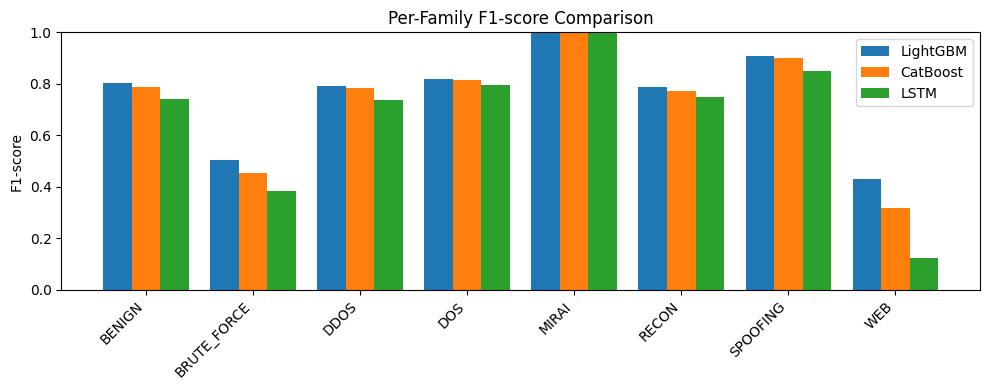

In [21]:
import matplotlib.pyplot as plt
# Get class names directly from the label encoder
class_names = list(le.classes_)

# Choose the models you want to compare per family
# (tree = uses X_test, dl = uses X_test_seq)
top_models = {
    "LightGBM": ("tree", lgbm),
    "CatBoost": ("tree", cat),
    "LSTM": ("dl", lstm),
}

f1_scores_per_model = {}

for model_name, (kind, model) in top_models.items():
    if kind == "tree":
        y_pred = model.predict(X_test)
    else:  # deep learning models
        y_proba = model.predict(X_test_seq)
        y_pred = np.argmax(y_proba, axis=1)

    report = classification_report(
        y_test,
        y_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0,
    )

    f1_scores_per_model[model_name] = [
        report[cls_name]["f1-score"] for cls_name in class_names
    ]

# Plot grouped bar chart
x = np.arange(len(class_names))
n_models = len(f1_scores_per_model)
width = 0.8 / n_models  # distribute bars within group

fig, ax = plt.subplots(figsize=(10, 4))

for i, (model_name, f1_values) in enumerate(f1_scores_per_model.items()):
    offset = (i - (n_models - 1) / 2) * width
    ax.bar(x + offset, f1_values, width, label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_ylabel("F1-score")
ax.set_ylim(0, 1.0)
ax.set_title("Per-Family F1-score Comparison")
ax.legend()
plt.tight_layout()
plt.show()

### 7.2 Global Metrics Comparison Across Models

This subsection compares overall accuracy and macro-averaged F1-score across all models.


7727/7727 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
7727/7727 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step
7727/7727 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


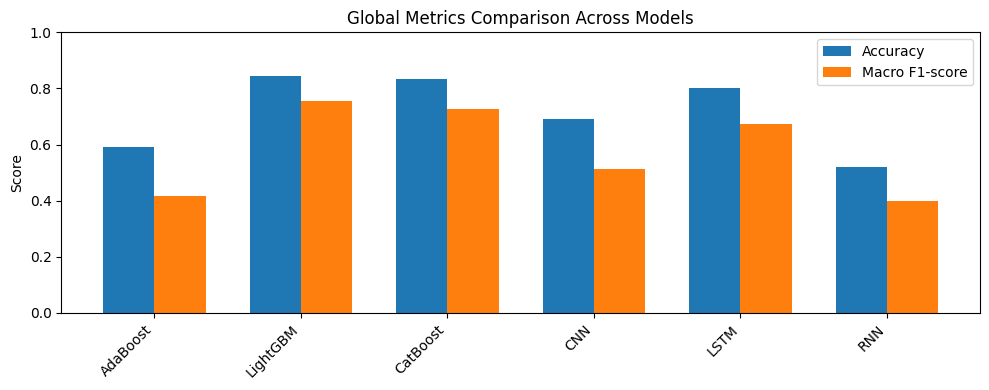

In [22]:
from sklearn.metrics import accuracy_score

# All models you trained in this notebook
# (tree = classical on X_test, dl = deep learning on X_test_seq)
all_models = {
    "AdaBoost": ("tree", ada),
    "LightGBM": ("tree", lgbm),
    "CatBoost": ("tree", cat),
    "CNN": ("dl", cnn),
    "LSTM": ("dl", lstm),
    "RNN": ("dl", rnn),
}

model_names = []
accuracies = []
macro_f1_scores = []

for model_name, (kind, model) in all_models.items():
    if kind == "tree":
        y_pred = model.predict(X_test)
    else:  # deep learning models
        y_proba = model.predict(X_test_seq)
        y_pred = np.argmax(y_proba, axis=1)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0,
    )
    macro_f1 = report["macro avg"]["f1-score"]

    model_names.append(model_name)
    accuracies.append(acc)
    macro_f1_scores.append(macro_f1)

model_names = np.array(model_names)
accuracies = np.array(accuracies)
macro_f1_scores = np.array(macro_f1_scores)

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(x - width / 2, accuracies, width, label="Accuracy")
ax.bar(x + width / 2, macro_f1_scores, width, label="Macro F1-score")

ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.set_title("Global Metrics Comparison Across Models")
ax.legend()
plt.tight_layout()
plt.show()

### 7.3 Interpretation of Model Comparison Visualizations

---

#### 7.3.1 Per-Family F1-Score Comparison

- **High-performing families:** BENIGN, MIRAI, SPOOFING — all models classify these reliably due to strong signals and large sample sizes.  
- **Moderate difficulty:** DDOS, DOS, RECON — performance varies but remains acceptable across models.  
- **Hardest families:** BRUTE_FORCE and especially WEB — very small sample sizes make these difficult for every model.  
- **Model ranking:** LightGBM is consistently strongest; CatBoost close behind; LSTM performs well but drops sharply on minority classes.

**Overall:** Class imbalance strongly shapes model performance, and minority families remain challenging even with deep learning.

---

#### 7.3.2 Global Metrics Comparison Across Models

- **Top performers:** LightGBM and CatBoost achieve the highest accuracy and macro F1, handling tabular IoT traffic most effectively.  
- **Deep-learning models:** LSTM performs competitively but still lags behind on minority classes; CNN and RNN show weaker, less stable results.  
- **Lowest performer:** AdaBoost struggles significantly with the complexity and imbalance of the dataset.

**Overall:** Gradient-boosted tree models clearly outperform deep learning for this tabular, highly imbalanced IoT dataset.

